# Phase 1: Data Import and Cleaning

**Purpose**:
- Import and parse the raw CSV data for UCSD course grade distributions.
- Clean and classify rows into "computable" (has GPA data) vs. "noncomputable".
- Save the cleaned DataFrame to disk for further analysis in Phase 2.

**Key Steps**:
1. Load raw CSV into `df`.
2. Parse letter grades, excluding non-traditional letters and “not available” rows.
3. Compute `enhanced_calculated_gpa`.
4. Mark each row with a `gpa_status`.
5. Serialize the cleaned `df` so Phase 2 can pick it up without re-running all cleaning steps.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# For inline plots in Jupyter
%matplotlib inline

In [3]:
# Define the path to the CSV file
data_file = os.path.join("..", "data", "Crowd-sourced grade distributions - Sheet1.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(data_file)

# Quick preview
print("Preview of the dataset:")
display(df.head())

# Basic info
print("\nDataFrame info:")
df.info()

print("\nMissing values per column:")
display(df.isnull().sum())

Preview of the dataset:


,Submission time,User ID,Term,Course,Professor,Grade distribution,Recommend professor?
0,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 120,"Voelker, Geoffrey M.","A+:11, A:41, A-:25, B+:41, B:28, B-:16, C+:12,...",NaN
1,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 132A,"Vianu, Victor Dan","A+:4, A:23, A-:19, B+:40, B:15, B-:27, C+:15, ...",NaN
2,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 141L,"Eldon, John","A+:1, A:28, A-:4, B+:2, B:0, B-:3, C+:0, C:3, ...",NaN
3,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 167,"Li, Tzumao","A+:102, A:22, A-:11, B+:5, B:7, B-:6, C+:2, C:...",NaN
4,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 230,"Jhala, Ranjit","A+:29, A:42, A-:26, B+:16, B:7, B-:1, C+:0, C:...",NaN



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9454 entries, 0 to 9453
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Submission time       9454 non-null   object 
 1   User ID               9454 non-null   object 
 2   Term                  9454 non-null   object 
 3   Course                9454 non-null   object 
 4   Professor             9454 non-null   object 
 5   Grade distribution    9454 non-null   object 
 6   Recommend professor?  0 non-null      float64
dtypes: float64(1), object(6)
memory usage: 517.1+ KB

Missing values per column:


Submission time            0
User ID                    0
Term                       0
Course                     0
Professor                  0
Grade distribution         0
Recommend professor?    9454
dtype: int64

### Processing & Cleaning Strategy

1. **Letter-Grade Parsing**  
   - Each row has a `Grade distribution` string, e.g. `"A+:12, A-:3, B:10, W:1, ..."`.
   - We split by commas, then by ":" to map each grade letter to its count.

2. **Standard vs. Non-Traditional**  
   - We define a `grade_points_map_lower` for standard letters (`"a", "b", "c", "d", "f"` and +/-).  
   - We define a `skip_letters` set for meta info or non-traditional letters (`p, np, w, i, ip, s, u, class gpa, total students, blank`).  
   - If a row indicates `"Grade Distribution is not available..."`, we consider that row entirely noncomputable.

3. **Compute Average GPA**  
   - Sum of (grade_count × letter_GPA_value) / total_students for that row.
   - If `total_students == 0`, return `None`.

4. **Handling Pandas NaN**  
   - When `None` is stored in a DataFrame cell, it becomes `NaN`. We use `pd.notna()` to check if the computed GPA is a valid number. Otherwise, it’s "noncomputable."

5. **Classification**  
   - We create a `gpa_status` column: `"computable"` if `enhanced_calculated_gpa` is a valid float, `"noncomputable"` if it’s `NaN`.

6. **Outcome**  
   - We'll see how many rows are computable vs. noncomputable, then show a distribution histogram of `enhanced_calculated_gpa`.

In [5]:
grade_points_map_lower = {
    "a+": 4.0, "a": 4.0, "a-": 3.7,
    "b+": 3.3, "b": 3.0, "b-": 2.7,
    "c+": 2.3, "c": 2.0, "c-": 1.7,
    "d+": 1.3, "d": 1.0, "d-": 0.7,
    "f": 0.0
}

skip_letters = {
    "class gpa", "total students", "blank",
    "p", "np", "s", "u", "w", "i", "ip"
}

def parse_grade_distribution_enhanced(dist_str):
    dist_str_lower = dist_str.lower()
    if "not available" in dist_str_lower:
        return {}
    grades = {}
    parts = dist_str.split(',')
    for part in parts:
        part = part.strip()
        if not part:
            continue
        letter_count = part.split(':')
        if len(letter_count) == 2:
            letter_raw, count_str = letter_count
            letter_lower = letter_raw.strip().lower()

            if letter_lower in skip_letters:
                continue

            try:
                count = int(count_str.strip())
            except ValueError:
                count = 0

            if letter_lower in grade_points_map_lower:
                grades[letter_lower] = grades.get(letter_lower, 0) + count
    return grades

def compute_average_gpa_enhanced(grades_dict):
    total_students = 0
    total_points = 0.0
    for letter_lower, cnt in grades_dict.items():
        if letter_lower in grade_points_map_lower:
            total_students += cnt
            total_points += cnt * grade_points_map_lower[letter_lower]
    if total_students == 0:
        return None
    return total_points / total_students

In [6]:
df["enhanced_grade_dict"] = df["Grade distribution"].astype(str).apply(parse_grade_distribution_enhanced)
df["enhanced_calculated_gpa"] = df["enhanced_grade_dict"].apply(compute_average_gpa_enhanced)

import pandas as pd

def classify_gpa_status(gpa_value):
    # Use pd.notna() to handle NaN
    return "computable" if pd.notna(gpa_value) else "noncomputable"

df["gpa_status"] = df["enhanced_calculated_gpa"].apply(classify_gpa_status)

print("Finished parsing and classifying. Sample rows:")
display(df.head(10))

Finished parsing and classifying. Sample rows:


,Submission time,User ID,Term,Course,Professor,Grade distribution,Recommend professor?,enhanced_grade_dict,enhanced_calculated_gpa,gpa_status
0,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 120,"Voelker, Geoffrey M.","A+:11, A:41, A-:25, B+:41, B:28, B-:16, C+:12,...",NaN,"{'a+': 11, 'a': 41, 'a-': 25, 'b+': 41, 'b': 2...",3.137864,computable
1,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 132A,"Vianu, Victor Dan","A+:4, A:23, A-:19, B+:40, B:15, B-:27, C+:15, ...",NaN,"{'a+': 4, 'a': 23, 'a-': 19, 'b+': 40, 'b': 15...",2.966463,computable
2,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 141L,"Eldon, John","A+:1, A:28, A-:4, B+:2, B:0, B-:3, C+:0, C:3, ...",NaN,"{'a+': 1, 'a': 28, 'a-': 4, 'b+': 2, 'b': 0, '...",3.366667,computable
3,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 167,"Li, Tzumao","A+:102, A:22, A-:11, B+:5, B:7, B-:6, C+:2, C:...",NaN,"{'a+': 102, 'a': 22, 'a-': 11, 'b+': 5, 'b': 7...",3.709756,computable
4,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 230,"Jhala, Ranjit","A+:29, A:42, A-:26, B+:16, B:7, B-:1, C+:0, C:...",NaN,"{'a+': 29, 'a': 42, 'a-': 26, 'b+': 16, 'b': 7...",3.743443,computable
5,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Spring Qtr 2023,CSE 101,"Jones, Miles E","A+:44, A:63, A-:45, B+:27, B:19, B-:11, C+:8, ...",NaN,"{'a+': 44, 'a': 63, 'a-': 45, 'b+': 27, 'b': 1...",3.475652,computable
6,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Spring Qtr 2023,CSE 105,"Minnes Kemp, Mor Mia","A+:11, A:52, A-:44, B+:25, B:47, B-:50, C+:28,...",NaN,"{'a+': 11, 'a': 52, 'a-': 44, 'b+': 25, 'b': 4...",2.923418,computable
7,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Spring Qtr 2023,CSE 110,"Powell, Thomas Allan","A+:0, A:17, A-:7, B+:9, B:6, B-:4, C+:1, C:0, ...",NaN,"{'a+': 0, 'a': 17, 'a-': 7, 'b+': 9, 'b': 6, '...",3.475556,computable
8,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Spring Qtr 2023,PHYS 2C,"Yang, Liang","A+:0, A:4, A-:3, B+:3, B:5, B-:6, C+:4, C:2, C...",NaN,"{'a+': 0, 'a': 4, 'a-': 3, 'b+': 3, 'b': 5, 'b...",2.942857,computable
9,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Winter Qtr 2023,CAT 125,"Bigham, David Joseph","A+:0, A:14, A-:4, B+:1, B:0, B-:0, C+:0, C:0, ...",NaN,"{'a+': 0, 'a': 14, 'a-': 4, 'b+': 1, 'b': 0, '...",3.900000,computable


Total rows: 9454
Computable rows: 8664
Noncomputable rows: 790
Percentage of computable rows: 91.64%


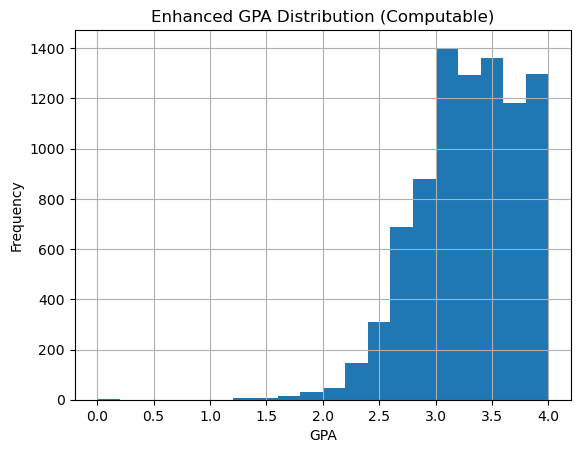

In [7]:
total_rows = len(df)
computable_rows = (df["gpa_status"] == "computable").sum()
noncomputable_rows = (df["gpa_status"] == "noncomputable").sum()

print(f"Total rows: {total_rows}")
print(f"Computable rows: {computable_rows}")
print(f"Noncomputable rows: {noncomputable_rows}")
print(f"Percentage of computable rows: {computable_rows / total_rows * 100:.2f}%")

df_computable = df[df["gpa_status"] == "computable"]
df_computable["enhanced_calculated_gpa"].hist(bins=20)
plt.title("Enhanced GPA Distribution (Computable)")
plt.xlabel("GPA")
plt.ylabel("Frequency")
plt.show()

In [8]:
# We'll use Pickle for easy reloading in Phase 2
output_file = os.path.join("..", "data", "cleaned_grades.pkl")
df.to_pickle(output_file)

print(f"Cleaned DataFrame saved to: {output_file}")

Cleaned DataFrame saved to: ../data/cleaned_grades.pkl


# Conclusion

We have successfully:
1. Imported the raw CSV.
2. Parsed standard letter grades and computed `enhanced_calculated_gpa`.
3. Classified rows into `"computable"` or `"noncomputable"`.
4. Saved the cleaned `df` to a pickle file (`cleaned_grades.pkl`) for future analysis.

**Next steps**: Open `02_exploratory_analysis.ipynb` or another downstream notebook.  
Load `cleaned_grades.pkl` and proceed with deeper GPA, course, or professor-level analysis.